In [108]:
import pandas as pd
import implicit
import os
import numpy as np
from scipy import sparse
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
%matplotlib inline

print(tf.__version__)

2.1.0


Решается задача товарных рекомендаций.

- `purchases_train.csv` - история покупок в розничном магазине (с 21 октября 2003 года по 12 марта 2004 года)

- `purchases_test.csv` - покупки за следующую неделю (с 13 по 19 марта 2004 года). В этой выборке для каждого пользователя исключены товары, которые он уже покупал за период обучающей выборки

- `customers.csv` - пол клиентов

В решении ниже
- обучается модель GMF (Generative Matrix Factorization) на TensorFlow/Keras
- обучается модель MLP (Multi Layer Perceptron)
- сравнивается с тестовыми данными
- измеряется ее качество по метрике map@10
- данные о поле клиентов не используются

Улучшите решение с помощью информацию о поле клиентов

## Create Dataset

In [2]:
purchases_train = pd.read_csv('purchases_train.csv')

In [3]:
# уникальных customer_id в train
len(purchases_train['customer_id'].unique())

107491

In [4]:
len(purchases_train['product_id'].unique())

1792

In [5]:
ds_train = purchases_train[['customer_id', 'product_id']].sort_values('customer_id').reset_index().drop('index', axis=1)

In [6]:
# датасет для нейросети должен быть customer_id, product_id, y
# y = 1
# + y=0 по 100 random samples 
item_set = set(ds_train['product_id'].to_list())
users_set = set(ds_train['customer_id'].to_list())    

In [10]:
ds_train

,customer_id,product_id
0,107,1542
1,107,5449
2,351,965
3,357,12654
4,434,3921
...,...,...
351681,21696224,12401
351682,21696224,8102
351683,21696224,10342
351684,21696337,3121


In [11]:
# закодируем item_id и user_id

class IdEncoder:
    
    def __init__(self, item_set, users_set):
        self._item_list = list(item_set)
        self._user_list = list(users_set)
        self._set_length()
        
    def _set_length(self):
        self.num_users = len(self._user_list)
        self.num_items = len(self._item_list)
        
    def GetUserID(self, UserUID):
        # in case of Out-of-Range (unknown UserUID) -> Add 
        if UserUID in self._user_list:
            return self._user_list.index(UserUID)+1
        else:
            return 0

    def GetItemID(self, ItemUID):
        if ItemUID in self._item_list:
            return self._item_list.index(ItemUID)+1
        else:
            return 0
    
    def GetUserUID(self, UserId):
        if UserId <= self.num_users:
            return self._user_list[UserId-1]
        else:
            return 0
    
    def GetItemUID(self, ItemId):
        if ItemId <= self.num_items:
            return self._item_list[ItemId-1]
        else:
            return 0
    
idEncoder = IdEncoder(item_set, users_set)

# encode ids by left joins 
# left merge dataframes

if os.path.exists('df_user.pkl'):
    df_user = pd.read_pickle('df_user.pkl')
else:    
    user_ids = []
    user_uids = []
    for i,j in enumerate(idEncoder._user_list):
        user_ids.append(i+1)
        user_uids.append(j)
    # кодировка
    df_user = pd.DataFrame({'user_id': user_ids, 'user_uid': user_uids})    
    df_user.to_pickle('df_user.pkl')

if os.path.exists('df_item.pkl'):
    df_item = pd.read_pickle('df_item.pkl')
else:    
    item_ids = []
    item_uids = []
    for i,j in enumerate(idEncoder._item_list):
        item_ids.append(i+1)
        item_uids.append(j)

    df_item = pd.DataFrame({'item_id': item_ids, 'item_uid': item_uids})    
    df_item.to_pickle('df_item.pkl')

In [12]:
ds_train = ds_train.merge(df_user, left_on='customer_id', right_on='user_uid', how='left')
ds_train = ds_train.merge(df_item, left_on='product_id', right_on='item_uid', how='left')

In [13]:
ds_train.drop(['user_uid', 'item_uid'], axis=1)

,customer_id,product_id,user_id,item_id
0,107,1542,45,407
1,107,5449,45,1403
2,351,965,140,258
3,357,12654,146,1152
4,434,3921,181,1016
...,...,...,...,...
351681,21696224,12401,82257,1088
351682,21696224,8102,82257,1784
351683,21696224,10342,82257,568
351684,21696337,3121,82306,821


In [14]:
N_zero = 5 # количество target=0 подмешиваемых к target=1

customer_ids = []
product_ids = []
target = []

for u in list(users_set):
    target_items = set(ds_train[ds_train['customer_id'] == u]['product_id'].to_list())
    sample_zero_target = random.sample(list(item_set - target_items), N_zero)
    for i in target_items:
        customer_ids.append(u)
        product_ids.append(i)
        target.append(1)
    for i in sample_zero_target:
        customer_ids.append(u)
        product_ids.append(i)
        target.append(0)
ds1 = pd.DataFrame({
    'customer_id': customer_ids,
    'product_id': product_ids,
    'y': target
})        
#ds1[ds1['customer_id'] == 16252928]   

In [15]:
ds1 = ds1.merge(df_user, left_on='customer_id', right_on='user_uid', how='left')
ds1 = ds1.merge(df_item, left_on='product_id', right_on='item_uid', how='left')
ds1.drop(['user_uid', 'item_uid'], axis=1)

,customer_id,product_id,y,user_id,item_id
0,16252928,5868,1,1,1480
1,16252928,12106,0,1,1013
2,16252928,2903,0,1,757
3,16252928,2245,0,1,597
4,16252928,7477,0,1,1700
...,...,...,...,...,...
878222,7864317,12174,0,107491,1037
878223,7864317,3692,0,107491,962
878224,7864317,7580,0,107491,1712
878225,7864317,1254,0,107491,340


### Test dataset

In [22]:
purchases_test = pd.read_csv('purchases_test.csv')
display(
    purchases_test.head(),
    purchases_test.shape
)

,customer_id,product_id,datetime
0,1021292,6197,2004-03-18 13:35:19.145152000
1,11379978,4659,2004-03-19 18:51:31.887936000
2,13271885,5659,2004-03-14 05:47:21.544166400
3,13271885,1015,2004-03-15 14:41:19.702089601
4,12315337,12072,2004-03-19 10:39:17.148105600


(21935, 3)

In [46]:
ds_test = purchases_test[['customer_id', 'product_id']]
ds_test = ds_test.merge(df_user, left_on='customer_id', right_on='user_uid', how='left')
ds_test = ds_test.merge(df_item, left_on='product_id', right_on='item_uid', how='left')
ds_test = ds_test[list(set(ds_test.columns)-set(['user_uid', 'item_uid']))]
print(len(ds_test))
ds_test.dropna(axis=0, inplace=True) # drop unknown items
print(len(ds_test))
ds_test['item_id'] = ds_test['item_id'].apply(lambda x: int(x))
ds_test.head()

21935
21928


,customer_id,item_id,product_id,user_id
0,1021292,1527,6197,96527
1,11379978,1199,4659,44352
2,13271885,1456,5659,67571
3,13271885,272,1015,67571
4,12315337,1006,12072,105343


### Prediction_matrix

In [73]:
ds_test_users = pd.DataFrame({ 'user_id': ds_test['user_id'].unique()})
print(len(ds_test_users))

# user_items_to_predict = df_user.merge(df_item, left_on='user_id', right_on='item_id', how='outer')
user_items_to_predict = df_user.merge(ds_test_users, on = 'user_id', how='inner').assign(foo=1).merge(df_item.assign(foo=1)).drop(['foo', 'user_uid', 'item_uid'], 1)

12501


In [76]:
print(len(df_item)*len(ds_test_users))
user_items_to_predict

22401792


,user_id,item_id
0,19,1
1,19,2
2,19,3
3,19,4
4,19,5
...,...,...
22401787,107490,1788
22401788,107490,1789
22401789,107490,1790
22401790,107490,1791


## Embeddings with Keras

In [16]:
n_factors = 20
n_items = idEncoder.num_items
n_users = idEncoder.num_users

# creating item embedding path
item_input = keras.layers.Input(shape=[1], name="Item-Input")
item_embedding = keras.layers.Embedding(n_items+1, n_factors, name="Item-Embedding")(item_input)
item_vec = keras.layers.Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = keras.layers.Input(shape=[1], name="User-Input")
user_embedding = keras.layers.Embedding(n_users+1, n_factors, name="User-Embedding")(user_input)
user_vec = keras.layers.Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = keras.layers.Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = keras.models.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 20)        35860       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        2149840     User-Input[0][0]                 
______________________________________________________________________________________________

Train on 878227 samples
Epoch 1/5
878227/878227 [==============================] - 4690s 5ms/sample - loss: 0.2743
Epoch 2/5
878227/878227 [==============================] - 471s 537us/sample - loss: 0.1226
Epoch 3/5
878227/878227 [==============================] - 981s 1ms/sample - loss: 0.0732
Epoch 4/5
878227/878227 [==============================] - 539s 614us/sample - loss: 0.0528
Epoch 5/5
878227/878227 [==============================] - 3732s 4ms/sample - loss: 0.0418


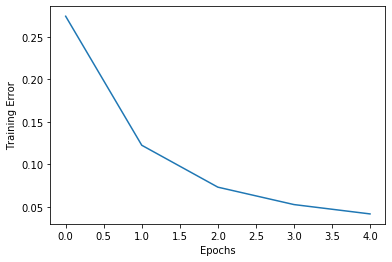

In [18]:
if os.path.exists('gncf.h5'):
    model = keras.models.load_model('gncf.h5')
else:
    history = model.fit([ds1.user_id, ds1.item_id], ds1.y, epochs=5, verbose=1)
    model.save('gncf.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [119]:
ds_test['y'] = 1
model.evaluate([ds_test.user_id, ds_test.item_id], ds_test.y)

21928/21928 [==============================] - 0s 18us/sample - loss: 0.2558


0.25576554694909853

In [103]:
def predict_user(user_id, source, model, top = 10):
    matrix = pd.DataFrame(source[source['user_id'] == user_id])
    matrix['predict'] = model.predict([matrix.user_id, matrix.item_id])
    matrix = matrix.sort_values(by='predict', ascending=False)
    #print(len(matrix[matrix['predict'] >= 1]))
    s = {'items': matrix['item_id'].head(top).to_list(),
        'prediction': matrix['predict'].head(top).to_list()}
    return s

def test_user(user_id, source, top=10000):
    return source[source['user_id'] == user_id]['item_id'].head(top).to_list()


# такой подсчет MAP@K был реализован в baselime mindbox
# он отличается от нашего, но оставим так для стравнения с baseline ALS Mindbox
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len(actual) == 0:
        return 0.0

    # return score / min(len(actual), k)
    return score / k

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])
    
#user_items_to_predict['predict_1'] = model.predict([user_items_to_predict.user_id, user_items_to_predict.item_id])

In [107]:
len(ds_test_users)

12501

In [111]:
aps = []
for i in tqdm(range(12501)):
    actual = test_user(ds_test_users['user_id'].to_list()[i], ds_test)
    predicted = predict_user(ds_test_users['user_id'].to_list()[i], user_items_to_predict, model)['items']
    aps.append(apk(actual, predicted, 10))
    
    # print('actual: ', actual)
    # print('predicted: ', predicted)
    # print('AP@10: ', apk(actual, predicted, 10))
print('MAP@10:',np.mean(aps))


MAP@10: 0.010470063982183012


MLP

In [19]:
n_factors = 20
n_items = idEncoder.num_items
n_users = idEncoder.num_users

# creating item embedding path
item_input = keras.layers.Input(shape=[1], name="Item-Input")
item_embedding = keras.layers.Embedding(n_items+1, n_factors, name="Item-Embedding")(item_input)
item_vec = keras.layers.Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = keras.layers.Input(shape=[1], name="User-Input")
user_embedding = keras.layers.Embedding(n_users+1, n_factors, name="User-Embedding")(user_input)
user_vec = keras.layers.Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = keras.layers.Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = keras.layers.Dense(128, activation='relu')(conc)
fc2 = keras.layers.Dense(32, activation='relu')(fc1)
out = keras.layers.Dense(1)(fc2)

# Create model and compile it
model2 = keras.models.Model([user_input, item_input], out)
model2.compile('adam', 'mean_squared_error')

In [20]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 20)        35860       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        2149840     User-Input[0][0]                 
____________________________________________________________________________________________

Train on 878227 samples
Epoch 1/5
878227/878227 [==============================] - 605s 689us/sample - loss: 0.1219
Epoch 2/5
878227/878227 [==============================] - 612s 697us/sample - loss: 0.0887
Epoch 3/5
878227/878227 [==============================] - 613s 698us/sample - loss: 0.0698
Epoch 4/5
878227/878227 [==============================] - 618s 704us/sample - loss: 0.0572
Epoch 5/5
878227/878227 [==============================] - 609s 693us/sample - loss: 0.0478


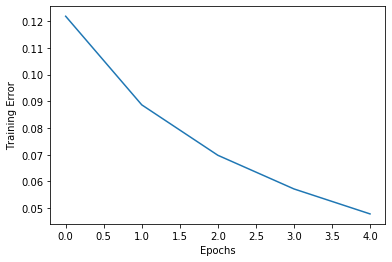

In [21]:
if os.path.exists('mlp.h5'):
    model2 = keras.models.load_model('mlp.h5')
else:
    history = model2.fit([ds1.user_id, ds1.item_id], ds1.y, epochs=5, verbose=1)
    model2.save('mlp.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [120]:
model2.evaluate([ds_test.user_id, ds_test.item_id], ds_test.y)

21928/21928 [==============================] - 0s 18us/sample - loss: 0.1542


0.15421846629659292

In [115]:
aps = []
for i in tqdm(range(12501)):
    actual = test_user(ds_test_users['user_id'].to_list()[i], ds_test)
    predicted = predict_user(ds_test_users['user_id'].to_list()[i], user_items_to_predict, model2)['items']
    aps.append(apk(actual, predicted, 10))
    
    # print('actual: ', actual)
    # print('predicted: ', predicted)
    # print('AP@10: ', apk(actual, predicted, 10))
print('MAP@10:',np.mean(aps))


MAP@10: 0.006119151737702254
